<a href="https://colab.research.google.com/github/lisaong/stackup-workshops/blob/shrink-model-2/mask-or-not/mask_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mask or Not

Trains a Neural Network Classifier to predict whether a face image is wearing a mask or not.

Converts the Neural Network Classifier into a Tensorflow-Lite model for deployment to an embedded device (such as an Arduino).

In [141]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
import pickle

In [142]:
!wget -q https://github.com/lisaong/stackup-workshops/raw/master/mask-or-not/data.zip -O data.zip
!unzip -o data.zip

Archive:  data.zip
  inflating: data/mask/1.jpg         
  inflating: data/mask/10.jpg        
  inflating: data/mask/2.jpg         
  inflating: data/mask/3.jpg         
  inflating: data/mask/4.jpg         
  inflating: data/mask/5.jpg         
  inflating: data/mask/6.jpg         
  inflating: data/mask/7.jpg         
  inflating: data/mask/8.jpg         
  inflating: data/mask/9.jpg         
  inflating: data/no_mask/1.jpg      
  inflating: data/no_mask/10.jpg     
  inflating: data/no_mask/2.jpg      
  inflating: data/no_mask/3.jpg      
  inflating: data/no_mask/4.jpg      
  inflating: data/no_mask/5.jpg      
  inflating: data/no_mask/6.jpg      
  inflating: data/no_mask/7.jpg      
  inflating: data/no_mask/8.jpg      
  inflating: data/no_mask/9.jpg      


In [143]:
# https://pythonprogramming.net/haar-cascade-face-eye-detection-python-opencv-tutorial/
# https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html
face_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_eye.xml')

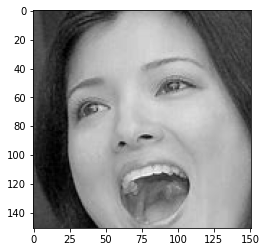

In [144]:
def detect(detector, path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = detector.detectMultiScale(img)

  for (x,y,w,h) in faces:
    face = img[y:y+h, x:x+w]
    plt.imshow(face, cmap='gray')
    plt.show()
  
detect(face_cascade, './data/no_mask/1.jpg')

In [145]:
detect(face_cascade, './data/mask/1.jpg')

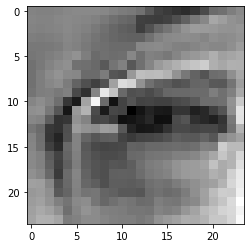

In [146]:
detect(eye_cascade, './data/mask/1.jpg')

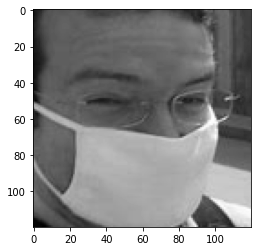

In [147]:
def crop_face(detector, eye_detector, path, output_size=(120, 120)):
  img = cv2.imread(path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  height, width, channels = img.shape

  # use the colour version for detection, but the
  # grayscale version for result
  faces = detector.detectMultiScale(img)
  eyes = eye_detector.detectMultiScale(img)

  face = None
  if len(faces) > 0:
    x,y,w,h = faces[0]
    face = gray[y:y+h, x:x+w]
  elif len(eyes) > 0:
    # mask is stumping haar face detection
    # approximate face by detecting the left eye
    x,y,w,h = eyes[0]
    # approximate face dimensions using the
    # left eye as reference
    face = gray[max(0, y-2*h):min(y+4*h, height), 
                max(0, x-3*w):min(x+2*w, width)]
  else:
    # nothing detected, just return original image
    face = gray

  face = cv2.resize(face, output_size)
  plt.imshow(face, cmap='gray')
  plt.show()
  return face

crop_face(face_cascade, eye_cascade, './data/mask/1.jpg');

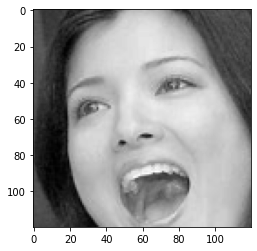

In [148]:
crop_face(face_cascade, eye_cascade, './data/no_mask/1.jpg');

2.jpg


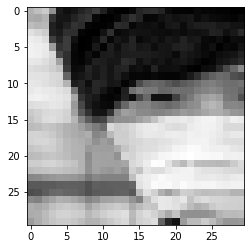

3.jpg


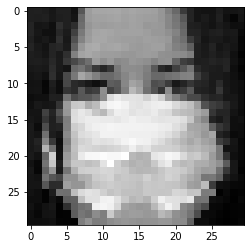

9.jpg


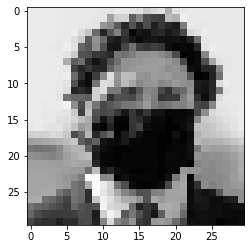

8.jpg


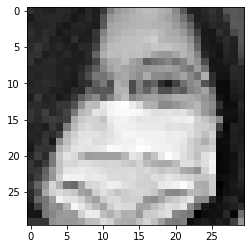

5.jpg


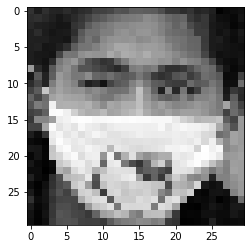

4.jpg


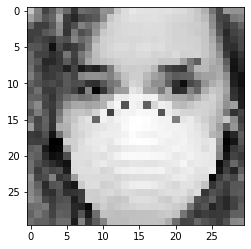

1.jpg


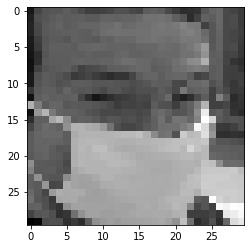

10.jpg


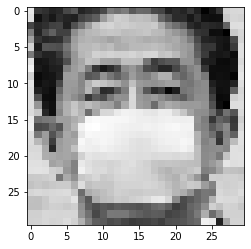

6.jpg


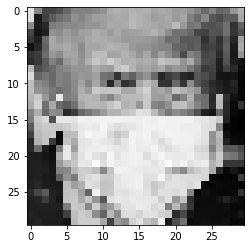

7.jpg


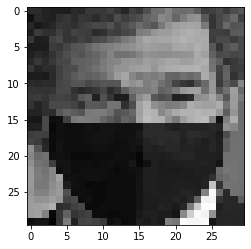

(10, 30, 30)

In [216]:
OUTPUT_SIZE = (30, 30)

def get_image_data(label):
  images = []
  for path in Path(f'./data/{label}').rglob('*.jpg'):
    print(path.name)
    images.append(np.array(crop_face(face_cascade, eye_cascade, 
                                     f'./data/{label}/{path.name}', 
                                     output_size=OUTPUT_SIZE)))
  return np.array(images)

images_mask = get_image_data('mask')
images_mask.shape

2.jpg


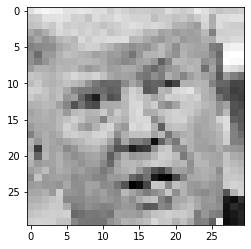

3.jpg


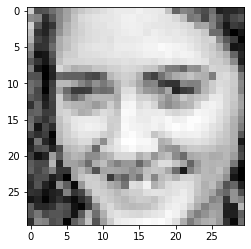

9.jpg


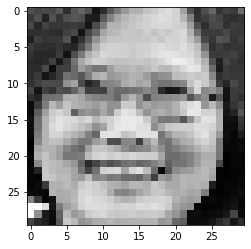

8.jpg


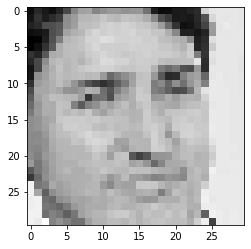

5.jpg


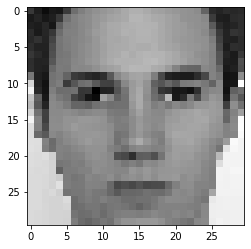

4.jpg


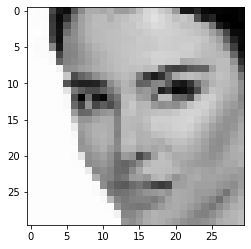

1.jpg


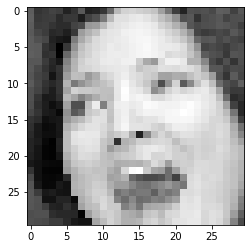

10.jpg


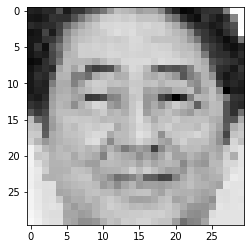

6.jpg


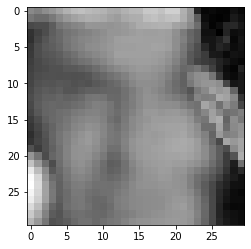

7.jpg


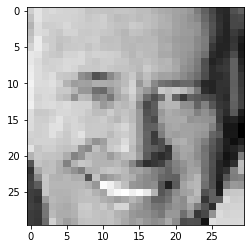

(10, 30, 30)

In [217]:
images_nomask = get_image_data('no_mask')
images_nomask.shape

In [218]:
labels = ['nomask'] * images_nomask.shape[0] + ['mask'] * images_mask.shape[0]
labels

['nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask']

In [219]:
images = np.vstack([images_nomask, images_mask])
images.shape

(20, 30, 30)

In [220]:
# flatten
X = images.reshape(-1, images.shape[1]*images.shape[2])
X.shape

(20, 900)

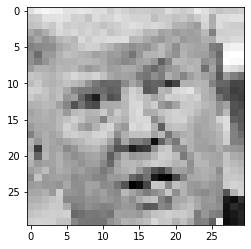

In [221]:
# can we get it back?
plt.imshow(X[0].reshape(images.shape[1], images.shape[2]), cmap='gray')
plt.show()

In [222]:
pca = PCA(n_components=.95)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# tune PCA
pca.fit(X_scaled)

pca.explained_variance_ratio_

array([0.23782727, 0.16341577, 0.14535538, 0.09474524, 0.05498984,
       0.05423754, 0.03297292, 0.03095714, 0.02893787, 0.02430133,
       0.0224027 , 0.01930378, 0.01756646, 0.01665538, 0.01422465])

In [223]:
np.arange(1, pca.n_components_+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

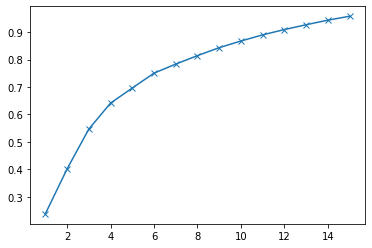

In [224]:
plt.plot(np.arange(1, pca.n_components_+1), pca.explained_variance_ratio_.cumsum(), marker='x')
plt.show()

In [225]:
# choose 5 features
pca = PCA(n_components=5)
Z = pca.fit_transform(X_scaled)

In [226]:
# let's do a pairplot
df = pd.DataFrame(Z)
df['label'] = labels
df.head()

0          1          2          3          4   label
0  6.888408  12.531799  -6.014719   1.677852   2.628528  nomask
1 -5.273697   2.480084 -11.425185   3.200342  -5.174388  nomask
2 -9.513277  -3.283667  -8.629256   5.165153 -12.837422  nomask
3 -0.175959  14.224527  -1.681390  -6.639382   6.073069  nomask
4  7.471829   3.593122  -2.580642 -12.037236   1.473375  nomask

In [227]:
# sns.pairplot(df, hue='label')

In [228]:
le = LabelEncoder()
y = le.fit_transform(labels)

In [229]:
X_train, X_test, y_train, y_test = train_test_split(Z, y, random_state=42, stratify=y)

In [230]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8

In [231]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.67      1.00      0.80         2

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



## Neural Networks

In [232]:
from tensorflow.keras import layers

mlp = tf.keras.Sequential()
mlp.add(layers.Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='relu'))
mlp.add(layers.Dense(X_train.shape[1]//2, activation='relu'))
mlp.add(layers.Dense(1, activation='sigmoid'))
mlp.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_41 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 3         
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


In [233]:
mlp.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = mlp.fit(X_train, y_train, batch_size=5, epochs=80,
                  validation_data=(X_test, y_test))

Epoch 1/80
3/3 [==============================] - 0s 36ms/step - loss: 2.5267 - accuracy: 0.6000 - val_loss: 2.9227 - val_accuracy: 0.6000
Epoch 2/80
3/3 [==============================] - 0s 11ms/step - loss: 2.4965 - accuracy: 0.6667 - val_loss: 2.9068 - val_accuracy: 0.6000
Epoch 3/80
3/3 [==============================] - 0s 10ms/step - loss: 2.4585 - accuracy: 0.6667 - val_loss: 2.8929 - val_accuracy: 0.6000
Epoch 4/80
3/3 [==============================] - 0s 10ms/step - loss: 2.4238 - accuracy: 0.6667 - val_loss: 2.8712 - val_accuracy: 0.6000
Epoch 5/80
3/3 [==============================] - 0s 10ms/step - loss: 2.3931 - accuracy: 0.6667 - val_loss: 2.8481 - val_accuracy: 0.6000
Epoch 6/80
3/3 [==============================] - 0s 9ms/step - loss: 2.3657 - accuracy: 0.6667 - val_loss: 2.8235 - val_accuracy: 0.6000
Epoch 7/80
3/3 [==============================] - 0s 10ms/step - loss: 2.3301 - accuracy: 0.6667 - val_loss: 2.8008 - val_accuracy: 0.6000
Epoch 8/80
3/3 [============

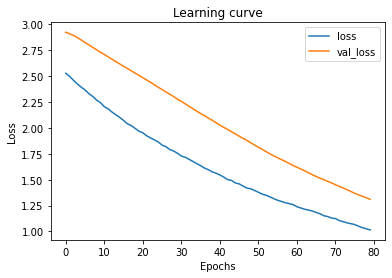

In [234]:
# learning curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [235]:
mlp.save('mlp.h5')

In [236]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.67      1.00      0.80         2

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



In [237]:
y_pred_mlp = mlp.predict(X_test) >= 0.5
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.00      0.00      0.00         2

    accuracy                           0.60         5
   macro avg       0.30      0.50      0.37         5
weighted avg       0.36      0.60      0.45         5



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Quantization to TFLite

https://www.tensorflow.org/lite/microcontrollers/build_convert

In [238]:
converter = tf.lite.TFLiteConverter.from_keras_model(mlp)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open('mlp.tflite', 'wb').write(tflite_model)

1620

In [239]:
# Test model loading
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='mlp.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

y_pred_tflite = []

# Test model on input data.
# Loop through each row of test_data and perform inference
for i in range(X_test.shape[0]):

  # add batch dimension
  input_data = np.expand_dims(X_test[i], axis=0).astype('float32')
  interpreter.set_tensor(input_details[0]['index'], input_data)
  interpreter.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data = interpreter.get_tensor(output_details[0]['index'])
  y_pred_tflite.append(output_data[0][0])

print(classification_report(y_test, np.array(y_pred_tflite) >= 0.5))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.00      0.00      0.00         2

    accuracy                           0.60         5
   macro avg       0.30      0.50      0.37         5
weighted avg       0.36      0.60      0.45         5



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [240]:
!pip install tinymlgen

In [241]:
# https://github.com/eloquentarduino/tinymlgen
import tinymlgen

c_code = tinymlgen.port(mlp)

with open('mlp.h', 'w') as f:
  f.write(c_code)

  # add defines that will be used by application code
  f.write(f'\n\n#define NUMBER_OF_INPUTS {mlp.get_input_shape_at(0)[1]}\n')
  f.write(f'#define NUMBER_OF_OUTPUTS {mlp.get_output_shape_at(0)[1]}\n')

print(c_code)


#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

const unsigned char model_data[] DATA_ALIGN_ATTRIBUTE = {0x08, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x7a, 0xfe, 0xff, 0xff, 0x03, 0x00, 0x00, 0x00, 0x14, 0x06, 0x00, 0x00, 0x70, 0x01, 0x00, 0x00, 0x58, 0x01, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x48, 0x01, 0x00, 0x00, 0x40, 0x01, 0x00, 0x00, 0x1c, 0x01, 0x00, 0x00, 0xfc, 0x00, 0x00, 0x00, 0xe8, 0x00, 0x00, 0x00, 0x74, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00, 0x24, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x58, 0xfa, 0xff, 0xff, 0x5c, 0xfa, 0xff, 0xff, 0x60, 0xfa, 0xff, 0xff, 0x64, 0xfa, 0xff, 0xff, 0x22, 0xff, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x08, 0x00,

In [242]:
with open('mlp.h', 'r') as f:
  print(f.read())


#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

const unsigned char model_data[] DATA_ALIGN_ATTRIBUTE = {0x08, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x7a, 0xfe, 0xff, 0xff, 0x03, 0x00, 0x00, 0x00, 0x14, 0x06, 0x00, 0x00, 0x70, 0x01, 0x00, 0x00, 0x58, 0x01, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x48, 0x01, 0x00, 0x00, 0x40, 0x01, 0x00, 0x00, 0x1c, 0x01, 0x00, 0x00, 0xfc, 0x00, 0x00, 0x00, 0xe8, 0x00, 0x00, 0x00, 0x74, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00, 0x24, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x58, 0xfa, 0xff, 0xff, 0x5c, 0xfa, 0xff, 0xff, 0x60, 0xfa, 0xff, 0xff, 0x64, 0xfa, 0xff, 0xff, 0x22, 0xff, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x08, 0x00,

## Port PCA to Arduino

https://eloquentarduino.github.io/2020/06/arduino-dimensionality-reduction-pca-for-machine-learning-projects/

In [243]:
!pip install micromlgen

In [244]:
import micromlgen

c_code = micromlgen.port(pca)
with open('pca.h', 'w') as f:
  f.write(c_code)

  # add defines that will be used by application code
  f.write(f'\n\n#define PCA_INPUT_SIZE {OUTPUT_SIZE[0]*OUTPUT_SIZE[1]}\n')

print(c_code)

#pragma once
namespace Eloquent {
    namespace ML {
        namespace Port {
            class PCA {
                public:
                    /**
                    * Apply dimensionality reduction
                    * @warn Will override the source vector if no dest provided!
                    */
                    void transform(float *x, float *dest = NULL) {
                        static float u[5] = { 0 };
                        u[0] = dot(x,   0.00506556963  , 0.023300612634  , 0.027974186513  , 0.031463462989  , 0.023036915937  , 0.02520516265  , 0.028907115168  , 0.025327533881  , 0.026249368547  , 0.026611270838  , 0.018562869313  , 0.007120368304  , -0.004632386572  , -0.009980353141  , -0.009072241507  , -0.010782962539  , -0.010857711231  , -0.001283463881  , 0.001775830812  , 0.003348172687  , 0.013486759972  , 0.018770599178  , 0.024959754895  , 0.024635138953  , 0.019921878208  , 0.019522652499  , 0.027228647216  , 0.00830489513  , 0.006147087511  , 0.00366785

In [245]:
with open('pca.h', 'r') as f:
  print(f.read())

#pragma once
namespace Eloquent {
    namespace ML {
        namespace Port {
            class PCA {
                public:
                    /**
                    * Apply dimensionality reduction
                    * @warn Will override the source vector if no dest provided!
                    */
                    void transform(float *x, float *dest = NULL) {
                        static float u[5] = { 0 };
                        u[0] = dot(x,   0.00506556963  , 0.023300612634  , 0.027974186513  , 0.031463462989  , 0.023036915937  , 0.02520516265  , 0.028907115168  , 0.025327533881  , 0.026249368547  , 0.026611270838  , 0.018562869313  , 0.007120368304  , -0.004632386572  , -0.009980353141  , -0.009072241507  , -0.010782962539  , -0.010857711231  , -0.001283463881  , 0.001775830812  , 0.003348172687  , 0.013486759972  , 0.018770599178  , 0.024959754895  , 0.024635138953  , 0.019921878208  , 0.019522652499  , 0.027228647216  , 0.00830489513  , 0.006147087511  , 0.00366785

In [246]:
# Continuous integration is enabled on this notebook
# store artifacts for CI testing

ci_artifacts = {
    'X' : X,
    'y' : y,
    'X_scaler' : scaler,
    'X_pca' : pca,
    'y_encoder' : le,
    'lr' : lr,
    'mlp_filename' : 'mlp.h5', 
    'tflite_filename': 'mlp.tflite',
    'h_filename' : 'mlp.h',
    'X_pca_h_filename' : 'pca.h'
}

pickle.dump(ci_artifacts, open('ci_artifacts.pkl', 'wb'))